In [1]:
import os
import json
import collections
data_path="/opt/ml/data/"
context_path= "wikipedia_documents.json"
with open(os.path.join(data_path, context_path), "r", encoding="utf-8") as f:
    wiki = json.load(f)

In [2]:
contexts = []

for key in wiki.keys() :
    data = wiki[key]
    context = data['text']
    contexts.append(context)

In [3]:
print('Data Size : %d' %len(contexts))

Data Size : 60613


In [4]:
print('Original Text \n')
contexts[0]

Original Text 



'이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.\n\n이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.\n\n# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.\n# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.\n\n두 목록은 모두 가나다 순이다.\n\n일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.'

In [5]:
contexts = [con.replace('\n*' , '') for con in contexts]
contexts = [con.replace('\n#' , '') for con in contexts]
contexts = [con.replace('\n' , '') for con in contexts]

In [6]:
print('Preprocessed Text \n')
contexts[0]

Preprocessed Text 



'이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.이 목록은 명료화를 위해 두 부분으로 나뉘어 있다. 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다. 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.두 목록은 모두 가나다 순이다.일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.'

## Part1 UNK Tokens in WIKI Data

In [7]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [8]:
import sys
sys.path.append('../')

In [9]:
import logging
import os
import sys
import re

import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List, Callable, NoReturn, NewType, Any
import dataclasses
from datasets import load_metric, load_from_disk, Dataset, DatasetDict

from transformers import AutoConfig, AutoModelForQuestionAnswering, AutoTokenizer
from transformers import (
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    TrainingArguments,
    set_seed,
)

In [10]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece

from utils_qa import postprocess_qa_predictions, check_no_error
from trainer_qa import QuestionAnsweringTrainer
from retrieval import SparseRetrieval

from arguments import (
    ModelArguments,
    DataTrainingArguments,
)

In [11]:
model_args = ModelArguments

config = AutoConfig.from_pretrained(
    model_args.config_name 
    if model_args.config_name is not None
    else model_args.model_name_or_path,
)

# -- Tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_args.tokenizer_name
    if model_args.tokenizer_name is not None
    else model_args.model_name_or_path,
    # 'use_fast' argument를 True로 설정할 경우 rust로 구현된 tokenizer를 사용할 수 있습니다.
    # False로 설정할 경우 python으로 구현된 tokenizer를 사용할 수 있으며,
    # rust version이 비교적 속도가 빠릅니다.
    use_fast=True,
)
 

In [12]:
tokenizer

PreTrainedTokenizerFast(name_or_path='klue/roberta-large', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [13]:
unk_id = tokenizer.convert_tokens_to_ids('[UNK]')

In [14]:
unk_words = []

for i , con in enumerate(tqdm(contexts)) :
    sen_list = sent_tokenize(con)
    for sen in sen_list :
        word_list = word_tokenize(sen)
        for word in word_list :
            if unk_id in tokenizer.encode(word) :
                unk_words.append((i,word))
            

100%|██████████| 60613/60613 [14:34<00:00, 69.30it/s]


In [15]:
print('Size of Words which make UNK Token : %d' %len(unk_words))

Size of Words which make UNK Token : 201192


In [16]:
for i in range(20,40) :
    print(unk_words[i])

(12, '펩타이드')
(13, '平仮名')
(13, 'ひらがな')
(13, 'おんなで')
(13, 'ㄸ+한자')
(13, 'ㅃ+한자')
(14, 'π의')
(15, 'Fourier級數')
(17, '統計')
(17, '슌친')
(17, '柳川春三')
(17, '統計司')
(17, '統計寮')
(19, '全數調査')
(19, '標本調査')
(24, '自然哲學-')
(24, '핼리도')
(24, '핼리도')
(24, '핼리')
(25, '大測')


## Check type of UNK Token words

In [17]:
kor_start_idx = int('AC00', 16)
kor_end_idx = int('D7A3', 16)

kor_chars = []
for i in range(kor_start_idx , kor_end_idx + 1) :
    kor_chars.append(chr(i))

In [18]:
jp_start_idx = int('3040', 16)
jp_end_idx = int('30FF', 16)

jp_chars = []
for i in range(jp_start_idx , jp_end_idx + 1) :
    jp_chars.append(chr(i))

In [19]:
ch_start_idx = int('4E00', 16)
ch_end_idx = int('9FFF', 16)

ch_chars = []
for i in range(ch_start_idx , ch_end_idx + 1) :
    ch_chars.append(chr(i))

In [20]:
def check_jp(word) :
    for ch in word :
        if ch not in jp_chars :
            return False
    return True

def check_kr(word) :
    for ch in word :
        if ch not in kor_chars :
            return False
    return True

def check_ch(word) :
    for ch in word :
        if ch not in ch_chars :
            return False
    return True


In [21]:
def check_unk(word) :
    if check_jp(word) :
        return 'jp'
    elif check_kr(word) :
        return 'kr'
    elif check_ch(word) :
        return 'ch'
    else :
        return 'unknown'

In [22]:
unk_kinds = [check_unk(unk[1]) for unk in unk_words]
unk_counter = collections.Counter()

In [23]:
unk_counter.update(unk_kinds)
unk_counter = dict(unk_counter)

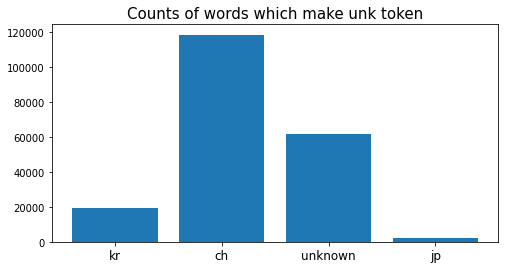

In [51]:
plt.figure(figsize = (8,4))

x_list = list(unk_counter.keys())
y_list = list(unk_counter.values())

plt.title('Counts of words which make unk token', fontsize = 15)
plt.bar(x_list, y_list)
plt.xticks(fontsize = 12)

plt.show()

## Part2 Check Special Characters (Not Korean, Chinese, Japanese)

In [25]:
sep_data = []

for con in tqdm(contexts) :
    sep_list = re.findall('[^一-鿸가-힣0-9぀-ヿa-zA-Z() ]', con)
    if len(sep_list) == 0 :
        continue
    sep_list = [sep for sep in sep_list if tokenizer.convert_tokens_to_ids(sep) == unk_id]
    sep_data.extend(sep_list)


100%|██████████| 60613/60613 [00:02<00:00, 27154.22it/s]


In [26]:
print('Sep Word Size : %d' %len(sep_data))

Sep Word Size : 136087


In [31]:
sep_data[:100]

['。',
 'α',
 'α',
 'α',
 'ㄸ',
 'ㅃ',
 'π',
 'ا',
 'ل',
 'ك',
 'ت',
 'ا',
 'ب',
 'ا',
 'ل',
 'م',
 'خ',
 'ت',
 'ص',
 'ر',
 'ف',
 'ي',
 'ح',
 'س',
 'ا',
 'ب',
 'ا',
 'ل',
 'ج',
 'ب',
 'ر',
 'و',
 'ا',
 'ل',
 'م',
 'ق',
 'ا',
 'ب',
 'ل',
 'ة',
 'ج',
 'ب',
 'ر',
 'ㅃ',
 'ㄸ',
 'ˈ',
 'ʃ',
 'ɔ',
 'ə',
 'ɛ',
 'ɡ',
 'ə',
 'ɐ',
 'ɔ',
 'ʏ',
 'ʃ',
 'ɐ',
 'ə',
 'ɛ',
 'ɡ',
 'ɐ',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000',
 '\u3000']

## Part3 Special Characters Position

In [28]:
inner_data = []

for con in tqdm(contexts) :
    inner_pos = re.findall(r'\([^가-힣0-9a-zA-Z )]*\)', con)
    inner_data.extend(inner_pos)

100%|██████████| 60613/60613 [00:00<00:00, 321395.96it/s]


In [29]:
print('Size of Special Word which is in () : %d' %len(inner_data))

Size of Special Word which is in () : 115134


In [30]:
inner_data[:10]

['(校正待ち)',
 '(本の未来基金)',
 '(週期表)',
 '(統計)',
 '(柳川春三)',
 '(統計司)',
 '(統計寮)',
 '(全數調査)',
 '(標本調査)',
 '(大測)']

In [32]:
inner_unk = [check_unk(word[1:-1]) for word in inner_data]

In [33]:
inner_unk_counter = collections.Counter()
inner_unk_counter.update(inner_unk)

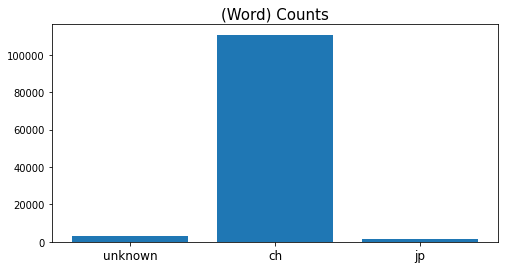

In [50]:
plt.figure(figsize = (8,4))

inner_x_list = list(inner_unk_counter.keys())
inner_y_list = list(inner_unk_counter.values())

plt.title('(Word) Counts', fontsize = 15)
plt.bar(inner_x_list, inner_y_list)
plt.xticks(fontsize = 12)

plt.show()

In [36]:
p_contexts = []
for con in tqdm(contexts) :
    con = re.sub(r'\([^)]*\)', '', con)
    p_contexts.append(con)

100%|██████████| 60613/60613 [00:00<00:00, 130306.47it/s]


In [41]:
p_unk_words = []
for i , con in enumerate(tqdm(p_contexts)) :
    sen_list = sent_tokenize(con)
    for sen in sen_list :
        word_list = word_tokenize(sen)
        for word in word_list :
            if unk_id in tokenizer.encode(word) :
                p_unk_words.append((i,word))
            

100%|██████████| 60613/60613 [13:42<00:00, 73.69it/s]


In [43]:
p_unk_kinds = [check_unk(unk[1]) for unk in p_unk_words]
p_unk_counter = collections.Counter()

In [44]:
p_unk_counter.update(p_unk_kinds)
p_unk_counter = dict(p_unk_counter)

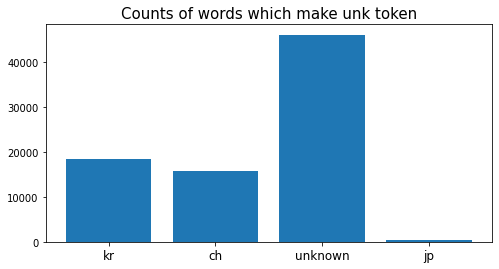

In [45]:
plt.figure(figsize = (8,4))

p_x_list = list(p_unk_counter.keys())
p_y_list = list(p_unk_counter.values())

plt.title('Counts of words which make unk token', fontsize = 15)
plt.bar(p_x_list, p_y_list)
plt.xticks(fontsize = 12)

plt.show()

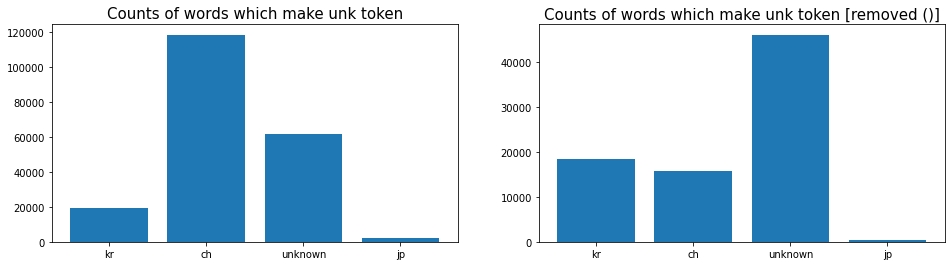

In [55]:
fig, axes = plt.subplots(1, 2, figsize = (16,4))

axes[0].set_title('Counts of words which make unk token', fontsize = 15)
axes[0].bar(x_list, y_list)

axes[1].set_title('Counts of words which make unk token [removed ()]', fontsize = 15)
axes[1].bar(p_x_list, p_y_list)

plt.show()

### 해석 

  1. 괄호안에 특수문자는 (한자) 가 대부분
  2. 괄호 () 안에 있는 내용을 전부 제거해도 한자가 어느 정도 존재
  3. 특수 문자 중에서는 특수 유니코드가 포함 되어있음
  4. 한글에 대한 대처가 필요할 것으로 생각 됨 (고유명사 인데 UNK 으로 변해버림 -> Mecab을 이용하거나 다른 방법이 필요)

In [56]:
p_unk_words[:100]

[(2, '쇤베르크'),
 (2, '쾰른'),
 (2, '쇤베르크'),
 (2, '쾰른의'),
 (2, '草月'),
 (2, '쮜리히에서'),
 (7, '青空｜文庫《ぶんこ》'),
 (7, "'ぶんこ"),
 (7, "'文庫"),
 (7, ':本日は晴天《せいてん》なり。'),
 (7, ':｜ブルースカイ《青空》'),
 (11, 'α-아미노산을'),
 (11, 'α-아미노산은'),
 (12, 'α-아미노산의'),
 (12, '펩타이드'),
 (13, 'ㄸ+한자'),
 (13, 'ㅃ+한자'),
 (14, 'π의'),
 (17, '슌친이'),
 (24, '핼리도'),
 (24, '핼리도'),
 (24, '핼리'),
 (26, '힉스'),
 (26, '힉스'),
 (26, '힉스'),
 (27, '힉스'),
 (27, '힉스'),
 (33, '뢴트겐에게'),
 (33, '그륀베르크가'),
 (33, '힉스와'),
 (35, 'ㅃ+한자'),
 (35, 'ㄸ과'),
 (36, "'片仮名'라는"),
 (36, "'カタカナ'라고"),
 (36, 'ヴ'),
 (36, "'ヴァ"),
 (36, 'ヴィ'),
 (36, 'ヴェ'),
 (36, 'ヴォ'),
 (37, 'カ'),
 (37, '加'),
 (37, '햅번이'),
 (56, '모뎀을'),
 (57, 'BPS모뎀을'),
 (57, '모뎀은'),
 (63, '고윳값과'),
 (63, '고윳값과'),
 (63, '고윳값을'),
 (63, '고윳값과'),
 (63, '고윳값과'),
 (63, '고윳값'),
 (65, '쥘리아는'),
 (66, '나뉠'),
 (71, 'π'),
 (72, '시솝'),
 (80, '푝력을'),
 (83, '데켐비리에'),
 (84, '훙왕'),
 (88, '쾨니히스베르크로'),
 (88, '쾨니히스베르크'),
 (88, '쾨니히스베르크'),
 (88, '쾨니히스베르크'),
 (94, '웁살라'),
 (110, '홋카이도'),
 (117, '기하치、혼다'),
 (117, '아키라、스즈키'),
 (117, '도

## Preprocessing

### Step1

In [ ]:
def remove_newline(txt) :
    txt = txt.replace('\n*' , '')
    txt = txt.replace('\n#' , '')
    txt = txt.replace('\n' , '')
    return txt

In [ ]:
remove_newline(contexts[13])

'히라가나(平仮名, ひらがな, Hiragana)는 일본어에서 사용하는 두 가지 가나 중 하나이다. 가타카나는 주로 외래어 표기 등에 쓰이고, 히라가나는 다음과 같은 용도로 쓰인다. 동사의 활용 어미, 조사, 조동사 일본 고유어로서 해당 한자가 없는 단어, 또는 해당하는 한자가 잘 쓰이지 않는 어려운 글자일 경우. 어린이가 사용하는 일본어의 뉘앙스를 보여 주고 싶을 때히라가나는 여성이 많이 썼다고 한다. 그래서 온나데(女手; おんなで)라고 불린 적도 있다. 이런 이유로 히라가나는 여자들만 쓰는 글이라 하여, 오랫동안 일본의 공용 문서에선 가타카나와 한자(칸지)만이 사용되었다. 현재 일본 철도의 역명판에는 히라가나와 칸지가 적혀 있다. 히라가나는 헤이안 시대부터 쓰인 것으로 알려져 있다. 일본의 유아들도 가나를 배울 때는 히라가나를 먼저 배우고 가타카나를 나중에 배우기 때문에 유아용 그림책 등에는 가타카나로 쓰인 단어 위에 히라가나를 후리가나로 덧붙이기도 한다. 음절문자이다.한영 자판 상태에서 히라가나를 입력할 경우 ㄸ+한자 키를 누르면 된다. 가타카나의 경우 장음 등 일부 문자를 제외하면, 꼭 ㅃ+한자 조합을 해야 한다.'

### Step 2

In [ ]:
unicode_comp1 = re.compile('[' + chr(0) + '-' + chr(31) + ']')
unicode_comp2 = re.compile('[' + chr(8191) + '-' + chr(12288) + ']')
unicode_comp3 = re.compile('[' + chr(55204) + '-' + chr(63743) + ']')

def remove_unicode(txt) :
    txt = unicode_comp1.sub(' ', txt)
    txt = unicode_comp2.sub(' ', txt)
    txt = unicode_comp3.sub(' ', txt)
    txt = re.sub('\s+' , ' ', txt)
    return txt

In [ ]:
a = contexts[60]
a

'KETEL의 초기화면\n\n\n\u3000CONNECT 240\n\u3000[[[[[[[\n\u3000### ketel에 연결되었습니다.(korea:pc\n\u3000### Welcome to ketel!!\n\u3000### 서비스 명에 ketel을 입력하십시오\n\u3000### Please type "ke" for KETEL English Service\n\u3000서비스 명(login):kete\n\n\n\u3000\u3000\u3000\u3000\u3000\u3000\u3000KK\u3000 KKK\u3000\u3000EEEEE\u3000TTTTTTTT\u3000\u3000EEEEEE\u3000 Lt\n\u3000\u3000\u3000\u3000\u3000\u3000 KK\u3000KK\u3000\u3000\u3000EE\u3000\u3000\u3000\u3000 \u3000TT\u3000\u3000\u3000 EE\u3000\u3000\u3000\u3000\n\u3000\u3000\u3000\u3000\u3000\u3000KKK\u3000\u3000\u3000\u3000 EEEE\u3000\u3000\u3000\u3000TT\u3000\u3000\u3000EEEE\u3000\u3000 L\n\u3000\u3000\u3000\u3000\u3000 KK KK\u3000\u3000\u3000 EE\u3000\u3000\u3000\u3000\u3000TT\u3000\u3000\u3000EE\u3000\u3000\u3000\u3000L\n\u3000\u3000\u3000\u3000\u3000KK\u3000 KKK\u3000EEEEEE\u3000\u3000 TT\u3000\u3000\u3000EEEEEE\u3000 LLLLLLL\n\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000 <<<알립니다>>\n\u30001.<<KETEL 정보서비스 일시 정지 안내>\n\u30002.KETE

In [ ]:
remove_unicode(a)

'KETEL의 초기화면 CONNECT 240 [[[[[[[ ### ketel에 연결되었습니다.(korea:pc ### Welcome to ketel!! ### 서비스 명에 ketel을 입력하십시오 ### Please type "ke" for KETEL English Service 서비스 명(login):kete KK KKK EEEEE TTTTTTTT EEEEEE Lt KK KK EE TT EE KKK EEEE TT EEEE L KK KK EE TT EE L KK KKK EEEEEE TT EEEEEE LLLLLLL <<<알립니다>> 1.<<KETEL 정보서비스 일시 정지 안내> 2.KETEL 전용 단말기 서비스 안 3.>>사용자 번호 변경 업무 개시< 4.>>KETEL ID 신청 메뉴 서비스 제공개시< 5.<<PC 라인 재판 발행> 6.<<동호회 신청 1차 마감... KETEL> 7.한경의 기사를 공모합니다 ** 공지사항을 보시겠습니까(번호/N/z) 사용자번호 : <<< 한경 KETEL >>> (TOP 1. 서비스 안내 2. KETEL-UNICOM NEW 11. 조선일보뉴스 12. 동아일보뉴스 13. 전남일보뉴 14. 부산일보뉴스 15. 영남일보뉴 19. 한국경제신문뉴 21. 증권/금융 22. 기업/경제통제 23. 무 24. 환율/금리 25. 중소기업지원 정 31. 유통/물가 32. 부동산 33. 세 34. 문화/레저 35. 날 41. 의/약/건강 42. 농업정 51. 전자우편 52. 게시판 53. 토론의 광 54. 대화실 55. 동호인 코너 56. 컴퓨터/통 57. PC 라 번호/명령(H,GO,PF,ME,Z,X >>'

In [ ]:
b = remove_newline(contexts[95])
b

'기타(Guitar)는 현(Strings)을 튕겨 소리를 내는\xa0발현악기로, 스페인 지방에서 유래하였다. 머리(Head), 목(Neck), 몸체(Body)로 구성되어 있으며, 목 부분에는 20여 개의 프렛(Fret)이 박혀 있다. 기타는 주로 6개의 현을 갖고 있다. 특이한 경우에는 머리가 없는 기타(Headless Guitar)나, 프렛이 없는 기타(Fretless Guitar)도 있다.\xa0클래식 음악뿐만 아니라\xa0재즈,\xa0록,\xa0팝 음악\xa0등 다양한 장르에 사용된다. 또한 기타를 연주하는 사람을\xa0기타리스트(Guitarist)라고 부른다.기타는 기타 몸체의 울림구멍(Sound Hole)을 통해 소리를 증폭하고, 프렛을 통해 음정을 제어한다. 현의 양 쪽에는 몸체의 브릿지(Bridge) 위에 위치한 하현주(Saddle)와 목 부분의 상현주(Nut)가 있다. 그리고 현의 장력을 조절하여 음정을 맞추는\xa0페그(Peg)가 머리에 고정되어 있다. 6개의 현은 연주를 위해 기타를 안았을 때 위쪽이 가장 굵고 아래쪽으로 갈수록 가늘어진다. 또한 현이 가늘어질수록 음역이 점점 높아진다. 목 부분에는 손가락을 짚는 지판(Finger Board)이 있는데, 지판 위의\xa0프렛에 현을 닿게 하여 음의 높낮이를 조절한다.기타의 종류로는, 몸체의 울림을 통해 소리를 증폭하는\xa0통기타(Acoustic Guitar)와 마그네틱 픽업(Pickup)과 앰프(Amplifier)를 통해 소리를 증폭하는\xa0전기 기타(Electric Guitar), 크게 2가지로 나뉜다.'

In [ ]:
remove_unicode(contexts[95])

'기타(Guitar)는 현(Strings)을 튕겨 소리를 내는 발현악기로, 스페인 지방에서 유래하였다. 머리(Head), 목(Neck), 몸체(Body)로 구성되어 있으며, 목 부분에는 20여 개의 프렛(Fret)이 박혀 있다. 기타는 주로 6개의 현을 갖고 있다. 특이한 경우에는 머리가 없는 기타(Headless Guitar)나, 프렛이 없는 기타(Fretless Guitar)도 있다. 클래식 음악뿐만 아니라 재즈, 록, 팝 음악 등 다양한 장르에 사용된다. 또한 기타를 연주하는 사람을 기타리스트(Guitarist)라고 부른다. 기타는 기타 몸체의 울림구멍(Sound Hole)을 통해 소리를 증폭하고, 프렛을 통해 음정을 제어한다. 현의 양 쪽에는 몸체의 브릿지(Bridge) 위에 위치한 하현주(Saddle)와 목 부분의 상현주(Nut)가 있다. 그리고 현의 장력을 조절하여 음정을 맞추는 페그(Peg)가 머리에 고정되어 있다. 6개의 현은 연주를 위해 기타를 안았을 때 위쪽이 가장 굵고 아래쪽으로 갈수록 가늘어진다. 또한 현이 가늘어질수록 음역이 점점 높아진다. 목 부분에는 손가락을 짚는 지판(Finger Board)이 있는데, 지판 위의 프렛에 현을 닿게 하여 음의 높낮이를 조절한다. 기타의 종류로는, 몸체의 울림을 통해 소리를 증폭하는 통기타(Acoustic Guitar)와 마그네틱 픽업(Pickup)과 앰프(Amplifier)를 통해 소리를 증폭하는 전기 기타(Electric Guitar), 크게 2가지로 나뉜다.'

### Step 3

In [74]:
ch_start_idx = int('4E00', 16)
ch_end_idx = int('9FFF', 16)

jp_start_idx = int('3040', 16)
jp_end_idx = int('30FF', 16)

In [77]:
ch_sub_str = re.compile('[' + chr(ch_start_idx) + '-' + chr(ch_end_idx) + ']+')
jp_sub_str = re.compile('[' + chr(jp_start_idx) + '-' + chr(jp_end_idx) + ']+')

In [79]:
def convert_foreign(txt) :
    txt = ch_sub_str.sub('[CHN]', txt)
    txt = jp_sub_str.sub('[JPN]', txt)
    return txt

In [80]:
contexts[13]

'히라가나(平仮名, ひらがな, Hiragana)는 일본어에서 사용하는 두 가지 가나 중 하나이다. 가타카나는 주로 외래어 표기 등에 쓰이고, 히라가나는 다음과 같은 용도로 쓰인다. 동사의 활용 어미, 조사, 조동사 일본 고유어로서 해당 한자가 없는 단어, 또는 해당하는 한자가 잘 쓰이지 않는 어려운 글자일 경우. 어린이가 사용하는 일본어의 뉘앙스를 보여 주고 싶을 때히라가나는 여성이 많이 썼다고 한다. 그래서 온나데(女手; おんなで)라고 불린 적도 있다. 이런 이유로 히라가나는 여자들만 쓰는 글이라 하여, 오랫동안 일본의 공용 문서에선 가타카나와 한자(칸지)만이 사용되었다. 현재 일본 철도의 역명판에는 히라가나와 칸지가 적혀 있다. 히라가나는 헤이안 시대부터 쓰인 것으로 알려져 있다. 일본의 유아들도 가나를 배울 때는 히라가나를 먼저 배우고 가타카나를 나중에 배우기 때문에 유아용 그림책 등에는 가타카나로 쓰인 단어 위에 히라가나를 후리가나로 덧붙이기도 한다. 음절문자이다.한영 자판 상태에서 히라가나를 입력할 경우 ㄸ+한자 키를 누르면 된다. 가타카나의 경우 장음 등 일부 문자를 제외하면, 꼭 ㅃ+한자 조합을 해야 한다.'

In [81]:
convert_chn(contexts[13])

'히라가나([CHN], [JPN], Hiragana)는 일본어에서 사용하는 두 가지 가나 중 하나이다. 가타카나는 주로 외래어 표기 등에 쓰이고, 히라가나는 다음과 같은 용도로 쓰인다. 동사의 활용 어미, 조사, 조동사 일본 고유어로서 해당 한자가 없는 단어, 또는 해당하는 한자가 잘 쓰이지 않는 어려운 글자일 경우. 어린이가 사용하는 일본어의 뉘앙스를 보여 주고 싶을 때히라가나는 여성이 많이 썼다고 한다. 그래서 온나데([CHN]; [JPN])라고 불린 적도 있다. 이런 이유로 히라가나는 여자들만 쓰는 글이라 하여, 오랫동안 일본의 공용 문서에선 가타카나와 한자(칸지)만이 사용되었다. 현재 일본 철도의 역명판에는 히라가나와 칸지가 적혀 있다. 히라가나는 헤이안 시대부터 쓰인 것으로 알려져 있다. 일본의 유아들도 가나를 배울 때는 히라가나를 먼저 배우고 가타카나를 나중에 배우기 때문에 유아용 그림책 등에는 가타카나로 쓰인 단어 위에 히라가나를 후리가나로 덧붙이기도 한다. 음절문자이다.한영 자판 상태에서 히라가나를 입력할 경우 ㄸ+한자 키를 누르면 된다. 가타카나의 경우 장음 등 일부 문자를 제외하면, 꼭 ㅃ+한자 조합을 해야 한다.'